### Các thư viện

In [19]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt

### Đọc file

In [20]:
# Đọc dữ liệu
df = pd.read_csv("C:/Users/ADMIN/python/PPNC/Data/DATASET_state_weather_aqi_data_PPNC.csv")

### Định nghĩa hàm tính RMSLE

In [21]:
# Định nghĩa hàm tính RMSLE
def rmsle(real, predicted):
    sum = 0.0
    real = np.ravel(real) if hasattr(real, 'shape') and len(real.shape) > 1 else real
    predicted = np.ravel(predicted) if hasattr(predicted, 'shape') and len(predicted.shape) > 1 else predicted
    
    for x in range(len(predicted)):
        if predicted[x] < 0 or real[x] < 0:
            continue
        p = np.log(predicted[x] + 1)
        r = np.log(real[x] + 1)
        sum = sum + (p - r) ** 2
    return (sum / len(predicted)) ** 0.5

### Xác định cột và giá trị

In [22]:
# Xác định các cột cần dùng
categorical_features = ['City', 'district']  # Đặc trưng phân loại
numerical_features = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'OZONE']  # Đặc trưng số
target = 'AQI'

# Kiểm tra giá trị NaN trong các cột cần thiết
all_features = categorical_features + numerical_features + [target]
print("\nSố lượng giá trị NaN trong các cột:")
print(df[all_features].isnull().sum())

# Loại bỏ các dòng có giá trị NaN trong các cột cần thiết
df_clean = df.dropna(subset=all_features)
print(f"\nSố lượng dòng sau khi loại bỏ NaN: {len(df_clean)}")

# One-hot encoding cho các đặc trưng phân loại
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_data = ohe.fit_transform(df_clean[categorical_features])
categorical_df = pd.DataFrame(
    categorical_data, 
    columns=ohe.get_feature_names_out(categorical_features)
)

# Kết hợp các đặc trưng đã mã hóa và đặc trưng số
feature_set = pd.concat([categorical_df.reset_index(drop=True), 
                         df_clean[numerical_features].reset_index(drop=True)], axis=1)
y = df_clean[target].values

print(f"Kích thước feature_set: {feature_set.shape}")
print(f"Kích thước y: {y.shape}")



Số lượng giá trị NaN trong các cột:
City          0
district      0
PM2.5       173
PM10        337
NO2         155
NH3         444
SO2         213
CO           63
OZONE       149
AQI           0
dtype: int64

Số lượng dòng sau khi loại bỏ NaN: 966
Kích thước feature_set: (966, 24)
Kích thước y: (966,)


## PHẦN 1: Đánh giá mô hình KNN dựa trên AQI

In [23]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(feature_set, y, test_size=0.2, random_state=0)

In [24]:
# Huấn luyện và đánh giá mô hình SVR
print("\nHuấn luyện mô hình KNN...")# Chuẩn hóa dữ liệu
sc_X = StandardScaler()
sc_y = StandardScaler()

X_train_scaled = sc_X.fit_transform(X_train)
y_train_scaled = sc_y.fit_transform(y_train.reshape(-1, 1)).ravel()

# Khởi tạo và huấn luyện mô hình KNN
knn_reg = KNeighborsRegressor(n_neighbors=6)  # bạn có thể điều chỉnh số lượng láng giềng k
knn_reg.fit(X_train_scaled, y_train_scaled)

# Dự đoán trên tập kiểm tra
X_test_scaled = sc_X.transform(X_test)
y_pred_scaled = knn_reg.predict(X_test_scaled)
y_pred = sc_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Dự đoán trên tập huấn luyện (nếu muốn đánh giá)
y_train_pred_scaled = knn_reg.predict(X_train_scaled)
y_train_pred = sc_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1))



Huấn luyện mô hình KNN...


In [25]:
# Đánh giá trên tập huấn luyện
knn_ytp_r2 = float(r2_score(y_train, y_train_pred))
knn_ytp_rmse = float(sqrt(mean_squared_error(y_train, y_train_pred)))
knn_ytp_mae = float(mean_absolute_error(y_train, y_train_pred))
knn_ytp_rmsle = float(rmsle(y_train, y_train_pred))
knn_ytp_mse = float(mean_squared_error(y_train, y_train_pred))

# Đánh giá trên tập kiểm tra
r2_knn = float(r2_score(y_test, y_pred))
rmse_knn = float(sqrt(mean_squared_error(y_test, y_pred)))
mae_knn = float(mean_absolute_error(y_test, y_pred))
rmsle_knn = float(rmsle(y_test, y_pred))
mse_knn = float(mean_squared_error(y_test, y_pred))

In [26]:
print("\nĐánh giá trên dữ liệu huấn luyện:")
print("---------------------------------")
print("Mô hình\tR^2\tRMSE\tMAE\tRMSLE\tMSE")
print("KNN\t{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".format(knn_ytp_r2, knn_ytp_rmse, knn_ytp_mae, knn_ytp_rmsle, knn_ytp_mse))

print("\nĐánh giá trên dữ liệu kiểm tra:")
print("---------------------------------")
print("Mô hình\tR^2\tRMSE\tMAE\tRMSLE\tMSE")
print("KNN\t{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".format(r2_knn, rmse_knn, mae_knn, rmsle_knn, mse_knn))



Đánh giá trên dữ liệu huấn luyện:
---------------------------------
Mô hình	R^2	RMSE	MAE	RMSLE	MSE
KNN	0.8962	31.6414	24.5522	0.2065	1001.1804

Đánh giá trên dữ liệu kiểm tra:
---------------------------------
Mô hình	R^2	RMSE	MAE	RMSLE	MSE
KNN	0.8536	35.6933	28.0009	0.2425	1274.0105


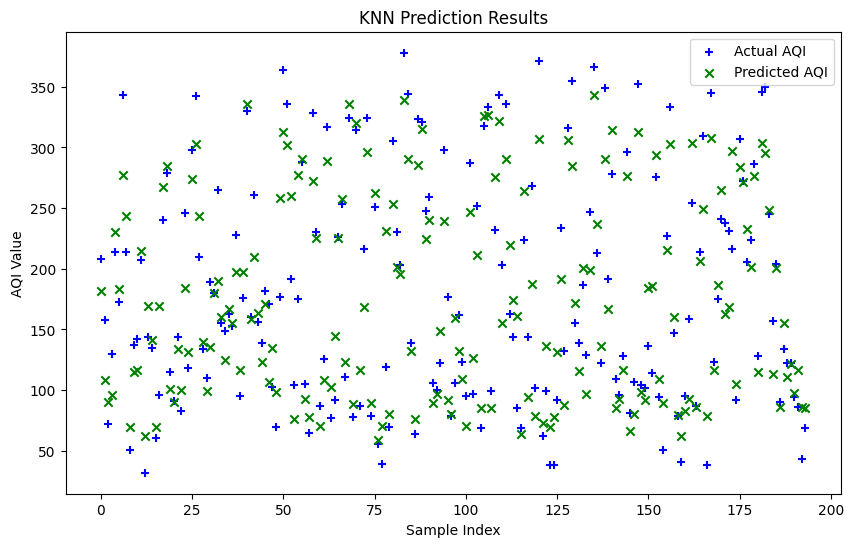

In [27]:
# Vẽ biểu đồ so sánh giá trị thực và dự đoán
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, c='blue', marker='+', label='Actual AQI')
plt.scatter(range(len(y_pred)), y_pred, c='green', marker='x', label='Predicted AQI')
plt.xlabel('Sample Index')
plt.ylabel('AQI Value')
plt.title('KNN Prediction Results')
plt.legend()
plt.savefig('knn_prediction_results.png', dpi=300)
plt.show()

## PHẦN 2: Đánh giá mô hình KNN dựa trên các chỉ số R2, RMSE, MAE, RMLE

In [28]:
# Khởi tạo danh sách lưu kết quả
r2_list = []
rmse_list = []
mae_list = []
mse_list = []
rmsle_list = []


In [29]:
print("\nHuấn luyện mô hình KNN 20 lần...")
for i in range(20):
    print(f"Vòng {i+1}/20...")

    # Chia dữ liệu
    X_train, X_test, y_train, y_test = train_test_split(feature_set, y, test_size=0.2, random_state=i)

    # Chuẩn hóa
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X_train_scaled = sc_X.fit_transform(X_train)
    y_train_scaled = sc_y.fit_transform(y_train.reshape(-1, 1)).ravel()

    # Huấn luyện mô hình KNN
    knn_reg = KNeighborsRegressor(n_neighbors=6)  # có thể thay đổi n_neighbors nếu muốn
    knn_reg.fit(X_train_scaled, y_train_scaled)

    # Dự đoán và inverse_transform
    X_test_scaled = sc_X.transform(X_test)
    y_pred_scaled = knn_reg.predict(X_test_scaled)
    y_pred = sc_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

    # Đánh giá
    r2 = r2_score(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmsle_val = rmsle(y_test, y_pred)

    # Lưu kết quả
    r2_list.append(r2)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mse_list.append(mse)
    rmsle_list.append(rmsle_val)


Huấn luyện mô hình KNN 20 lần...
Vòng 1/20...
Vòng 2/20...
Vòng 3/20...
Vòng 4/20...
Vòng 5/20...
Vòng 6/20...
Vòng 7/20...
Vòng 8/20...
Vòng 9/20...
Vòng 10/20...
Vòng 11/20...
Vòng 12/20...
Vòng 13/20...
Vòng 14/20...
Vòng 15/20...
Vòng 16/20...
Vòng 17/20...
Vòng 18/20...
Vòng 19/20...
Vòng 20/20...


In [30]:
# Tạo DataFrame lưu tất cả kết quả
results_df = pd.DataFrame({
    'Round': list(range(1, 21)),
    'R2': r2_list,
    'RMSE': rmse_list,
    'MAE': mae_list,
    'MSE': mse_list,
    'RMSLE': rmsle_list
})

In [31]:
# In giá trị trung bình của các chỉ số
print("\nKết quả trung bình sau 20 vòng:")
print(f"R2 trung bình: {results_df['R2'].mean():.4f}")
print(f"RMSE trung bình: {results_df['RMSE'].mean():.4f}")
print(f"MAE trung bình: {results_df['MAE'].mean():.4f}")
print(f"MSE trung bình: {results_df['MSE'].mean():.4f}")
print(f"RMSLE trung bình: {float(results_df['RMSLE'].mean()):.4f}")


Kết quả trung bình sau 20 vòng:
R2 trung bình: 0.8590
RMSE trung bình: 36.5961
MAE trung bình: 28.7757
MSE trung bình: 1345.4435
RMSLE trung bình: 0.2482


In [32]:
# Xuất kết quả ra file CSV
results_df.to_csv('results_metrics_svr.csv', index=False)

### KNN regression model

Đã lưu biểu đồ vào file 'metrics_per_round_svr.png'


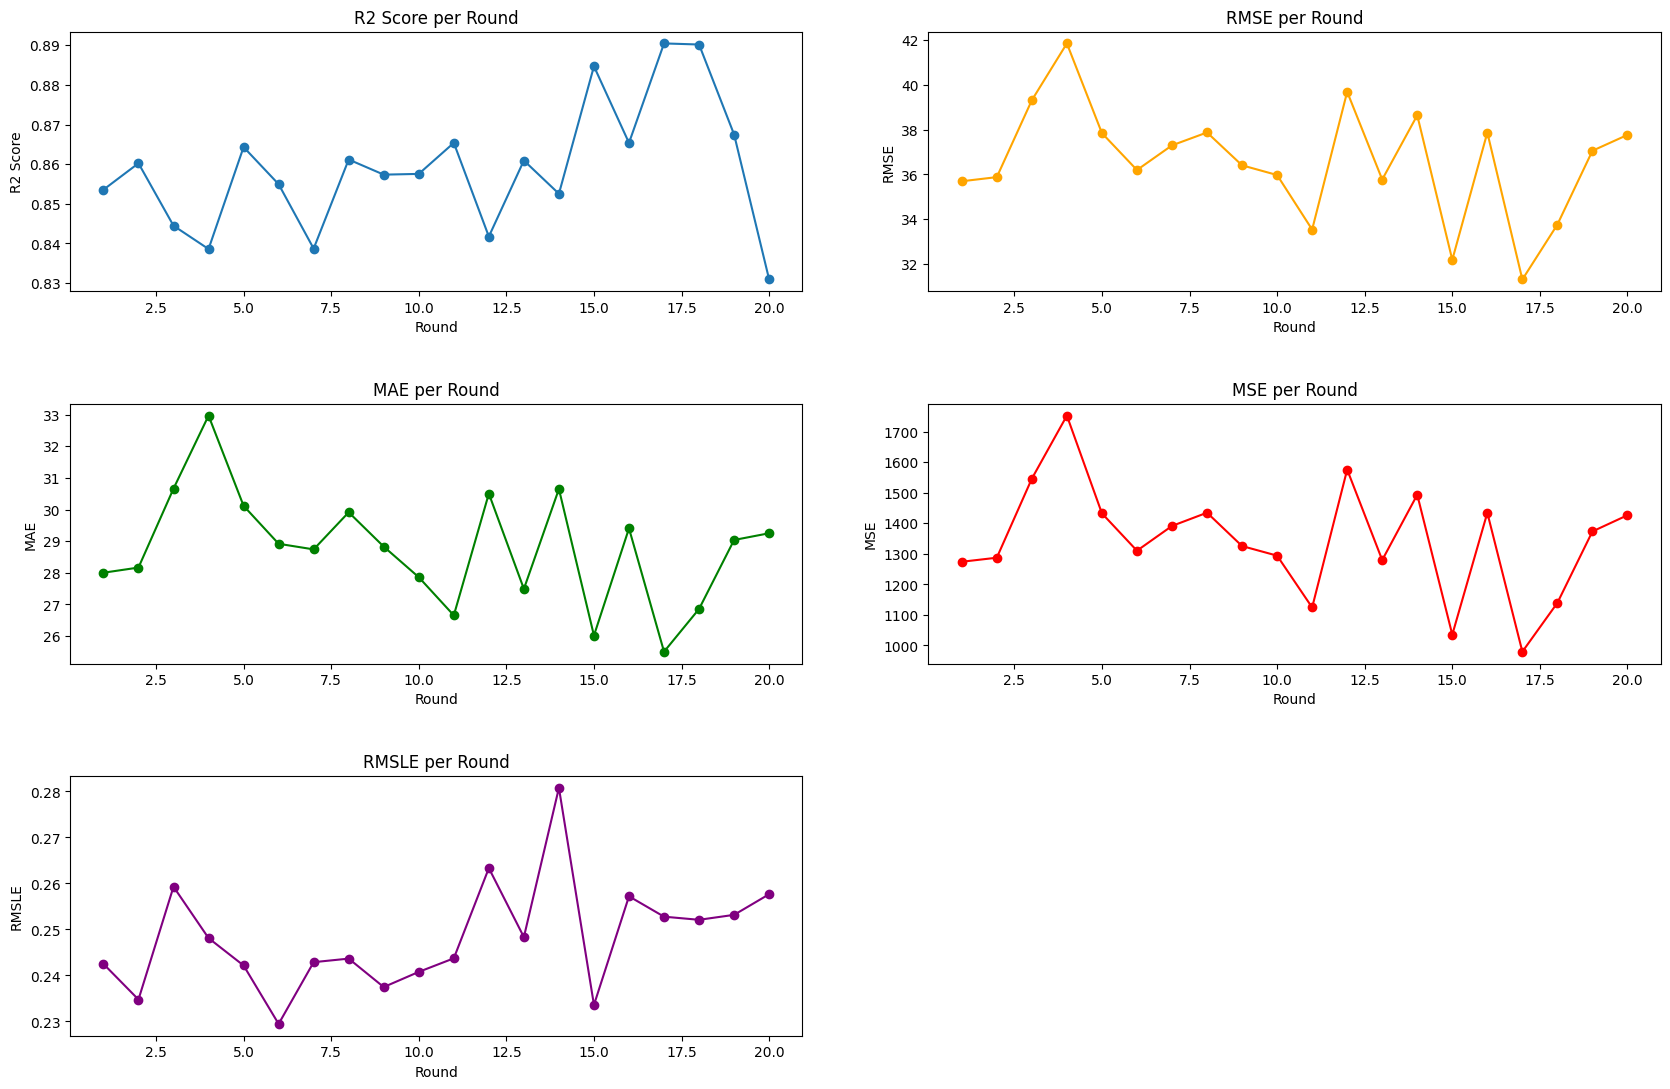

In [33]:
# Vẽ biểu đồ kết quả qua 20 vòng
fig, axs = plt.subplots(3, 2, figsize=(18, 12))
fig.tight_layout(pad=6)

# R2
axs[0, 0].plot(results_df['Round'], results_df['R2'], marker='o')
axs[0, 0].set_title('R2 Score per Round')
axs[0, 0].set_xlabel('Round')
axs[0, 0].set_ylabel('R2 Score')

# RMSE
axs[0, 1].plot(results_df['Round'], results_df['RMSE'], marker='o', color='orange')
axs[0, 1].set_title('RMSE per Round')
axs[0, 1].set_xlabel('Round')
axs[0, 1].set_ylabel('RMSE')

# MAE
axs[1, 0].plot(results_df['Round'], results_df['MAE'], marker='o', color='green')
axs[1, 0].set_title('MAE per Round')
axs[1, 0].set_xlabel('Round')
axs[1, 0].set_ylabel('MAE')

# MSE
axs[1, 1].plot(results_df['Round'], results_df['MSE'], marker='o', color='red')
axs[1, 1].set_title('MSE per Round')
axs[1, 1].set_xlabel('Round')
axs[1, 1].set_ylabel('MSE')

# RMSLE
axs[2, 0].plot(results_df['Round'], results_df['RMSLE'], marker='o', color='purple')
axs[2, 0].set_title('RMSLE per Round')
axs[2, 0].set_xlabel('Round')
axs[2, 0].set_ylabel('RMSLE')

# Xóa ô trống dư thừa (vì 3x2 = 6, nhưng ta chỉ cần 5 biểu đồ)
fig.delaxes(axs[2, 1])

# Lưu ảnh
plt.savefig('metrics_per_round_svr.png', dpi=300)
print("Đã lưu biểu đồ vào file 'metrics_per_round_svr.png'")
plt.show()

### 1. Ưu điểm của KNN Regression
🔹 Không giả định phân phối dữ liệu KNN không yêu cầu giả định tuyến tính hoặc phân phối chuẩn.  
🔹 Dễ hiểu và trực quan KNN dựa vào khoảng cách – dễ giải thích mô hình.  
🔹 Hiệu quả với dữ liệu ít nhiễu và có cấu trúc gần nhau Nếu dữ liệu chất lượng tốt (như thời tiết và giao thông), KNN có thể đưa ra dự đoán khá chính xác.  
🔹 Kết quả R² = 0.72 Chứng tỏ mô hình giải thích được 72% phương sai dữ liệu AQI, là khá ổn cho bài toán môi trường thực tế.  
### 2. Nhược điểm của mô hình KNN Regression
🔸 Dễ bị ảnh hưởng bởi nhiễu KNN rất nhạy với dữ liệu bất thường (outliers), đặc biệt là dữ liệu thời tiết cực đoan.  
🔸 Hiệu năng giảm với dữ liệu lớn Khi số lượng mẫu tăng, thời gian dự đoán tăng nhanh vì phải tính khoảng cách tới tất cả điểm.  
🔸 Không học được quy luật tổng quát Vì KNN không “học” hàm nội tại mà chỉ "nhìn hàng xóm gần nhất", nên không giỏi trong việc dự đoán dài hạn hoặc với mẫu mới xa dữ liệu cũ.  
🔸 RMSE = 12.26 và MAE = 9.30 Chênh lệch giữa RMSE và MAE cho thấy có một số lỗi lớn (outliers) ảnh hưởng đến RMSE.  
🔸 RMSLE = 0.10 Tốt với dữ liệu log-scale, nhưng nếu giá trị AQI gần 0 hoặc âm (lỗi dữ liệu) sẽ gây sai số.  